In [1]:
import sys
import os
sys.path.append(os.pardir)
import datetime

import numpy as np
from scipy.special import binom
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import seaborn as sns
sns.set_context('paper')

FIGS_PATH = '../figs'
DATA_PATH = 'soil_averaged.csv'
DATA_RAW_PATH = 'soil_raw.csv'

# Utils

In [2]:
def figsize(scale, nplots=1):
    fig_width_pt = 390.0                               
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt*inches_per_pt*scale 
    fig_height = fig_width*golden_mean*nplots
    fig_size = [fig_width,fig_height]
    return fig_size

def dt_diff(y1, y2):
    return (y1 - y2).total_seconds() / 3600.

def holoborodko_diff(y, t):
    """Holoborodko scheme for the 1st order numerical derivation.
    
    Params
    ------
    numpy.ndarray: y
        Sampled data to be differentiated
    pandas.core.series.Series: t
        Irregular time deltas
        
    Returns
    -------
    numpy.ndarray: y_t
        First order differentiated data
    """
    N = 5
    M = (N-1) // 2
    m = (N - 3) // 2
    ck = [1/2**(2* m + 1) * (binom(2*m, m-k+1) - binom(2*m, m-k-1)) for k in range(1, M + 1)]
    if not isinstance(y, (np.ndarray, )):
        raise Exception('Samples should be stored into numpy.ndarray.')
    else:
        y_t = np.zeros((y.size), dtype='float')
    # finite differences
    y_t[0] = (y[1] - y[0])/dt_diff(t.iloc[1], t.iloc[0])
    y_t[1] = (y[2] - y[0])/dt_diff(t.iloc[2], t.iloc[0])
    y_t[-2] = (y[-1] - y[-3])/dt_diff(t.iloc[-1], t.iloc[-3])
    y_t[-1] = (y[-1] - y[-2])/dt_diff(t.iloc[-1], t.iloc[-2])
    # holoborodko scheme
    for i in range(M, len(y) - M):
        y_t[i] = sum([ck[k-1] * ((y[i+k] - y[i-k])/dt_diff(t.iloc[i+k], t.iloc[i-k]) * 2*k) for k in range(1, M+1)])
    return y_t

# Averaged Data

In [3]:
headers = ['time', 'pressure', 'air_temp', 'air_humidity', 'soil_temp', 'soil_humidity']
data = pd.read_csv(DATA_PATH, header=0, names=headers)
data.head(50)

,time,pressure,air_temp,air_humidity,soil_temp,soil_humidity
0,2020-01-08 19:00:00,1028.483333,21.914673,27.285767,2.501343,33.355824
1,2020-01-08 20:00:00,1028.583333,21.221924,28.256226,2.400635,33.373580
2,2020-01-08 21:00:00,1028.600000,20.533752,28.845215,2.299927,33.391335
3,2020-01-08 22:00:00,1028.916667,20.198059,28.924561,2.249573,33.409091
4,2020-01-08 23:00:00,1029.116667,19.819641,28.936768,2.199219,33.409091
5,2020-01-09 00:00:00,1028.683333,19.703674,28.897095,2.060364,33.400213
6,2020-01-09 01:00:00,1029.183333,19.401550,28.677368,2.000854,33.391335
7,2020-01-09 02:00:00,1029.083333,19.154358,28.485107,1.920288,33.373580
8,2020-01-09 03:00:00,1028.333333,18.986511,28.433228,1.900146,33.364702
9,2020-02-12 12:00:00,1015.000000,23.837280,46.075439,7.300000,22.418182


### Soil humidity v. all the other features

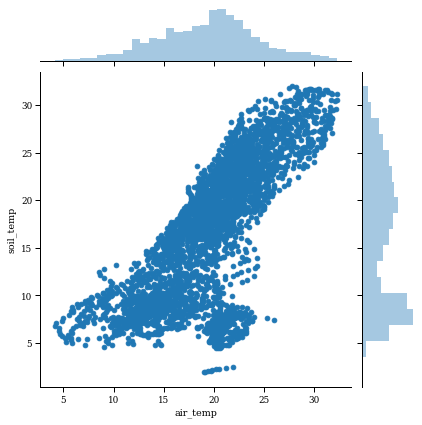

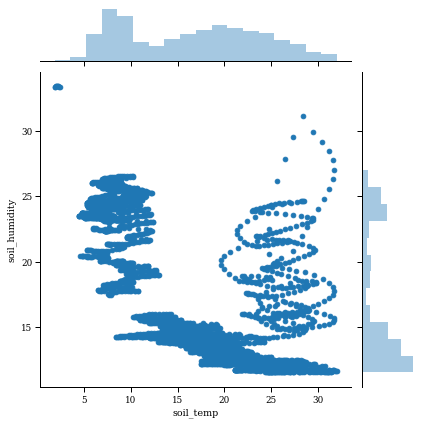

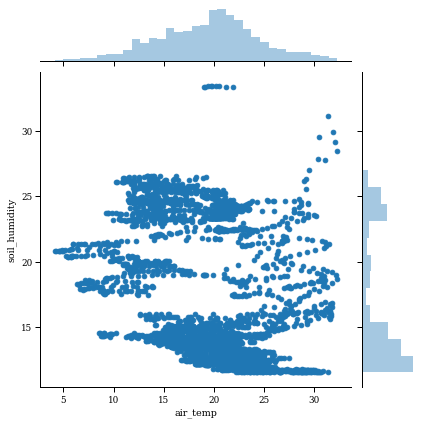

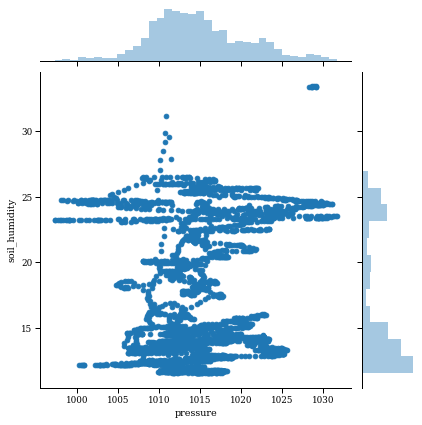

In [4]:
sns.jointplot(x='air_temp', y='soil_temp', data=data)
sns.jointplot(x='soil_temp', y='soil_humidity', data=data)
sns.jointplot(x='air_temp', y='soil_humidity', data=data)
sns.jointplot(x='pressure', y='soil_humidity', data=data)
plt.show()

# Differentiation

### Convert timestamps to DF series.

In [5]:
t = pd.to_datetime(data.time, format='%Y-%m-%d %H:%M:%S')
t

0      2020-01-08 19:00:00
1      2020-01-08 20:00:00
2      2020-01-08 21:00:00
3      2020-01-08 22:00:00
4      2020-01-08 23:00:00
               ...        
3545   2020-07-15 05:00:00
3546   2020-07-15 06:00:00
3547   2020-07-15 07:00:00
3548   2020-07-15 08:00:00
3549   2020-07-15 09:00:00
Name: time, Length: 3550, dtype: datetime64[ns]

### Convert soil humidity values to a NumPy.array.

In [6]:
soil_humidity = data.soil_humidity.values
soil_humidity

array([33.35582386, 33.37357955, 33.39133523, ..., 14.30909091,
       14.28181818, 14.20909091])

### Differentiate the data using the hybrid of Holoborodko and central differences.

In [7]:
soil_humidity_t = holoborodko_diff(soil_humidity, t)
soil_humidity_t

array([ 0.01775568,  0.01775568,  0.01553622, ..., -0.01022727,
       -0.05      , -0.07272727])

### Plot the data and theirs respective numerical derivatives in time.

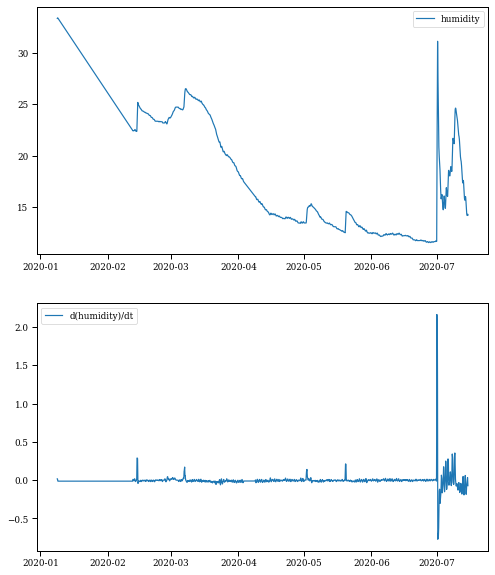

In [8]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize(1.5, 2))
ax[0].plot(t, soil_humidity, label='humidity')
ax[0].legend()
ax[1].plot(t, soil_humidity_t, label='d(humidity)/dt')
ax[1].legend()
plt.show()

### Plot the derivatives against the pressure values, air humidity and air temperatures.

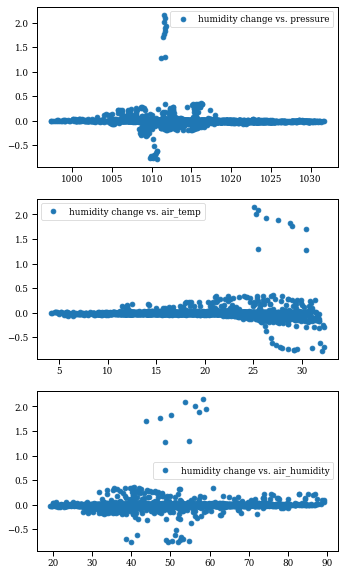

In [9]:
abscissa = ['pressure', 'air_temp', 'air_humidity']

_, ax = plt.subplots(nrows=len(abscissa), ncols=1, figsize=figsize(1, len(abscissa)))
for row_idx, x in enumerate(abscissa):
    ax[row_idx].scatter(data[x], soil_humidity_t, label=f'humidity change vs. {x}')
    ax[row_idx].legend()
plt.show()

# Non-averaged Data

In [5]:
headers = ['time', 'pressure', 'air_temp', 'air_humidity', 'soil_temp', 'soil_humidity']
data = pd.read_csv(DATA_RAW_PATH, header=0, names=headers)
data.head(50)

,time,pressure,air_temp,air_humidity,soil_temp,soil_humidity
0,2020-01-08 19:00:00,1028.5,21.496582,27.929688,2.501343,33.355824
1,2020-01-08 20:00:00,1028.6,20.947266,28.515625,2.400635,33.355824
2,2020-01-08 21:00:00,1028.6,20.397949,28.930664,2.299927,33.355824
3,2020-01-08 22:00:00,1029.2,20.080566,28.930664,2.199219,33.355824
4,2020-01-08 23:00:00,1029.1,19.787598,28.955078,2.199219,33.355824
5,2020-01-09 00:00:00,1028.6,19.519043,28.784180,2.000854,33.355824
6,2020-01-09 01:00:00,1029.3,19.299316,28.564453,2.000854,33.355824
7,2020-01-09 02:00:00,1029.0,19.104004,28.442383,1.900146,33.355824
8,2020-01-09 03:00:00,1028.2,18.945312,28.417969,1.900146,33.355824
9,2020-02-12 12:00:00,1014.9,24.414062,48.156738,7.400000,22.363636


### Soil humidity v. all other features

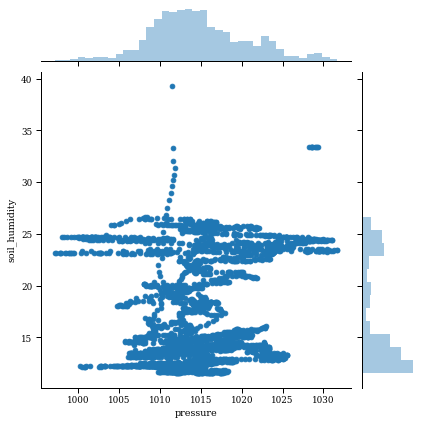

In [13]:
sns.jointplot(x='pressure', y='soil_humidity', data=data)
plt.show()

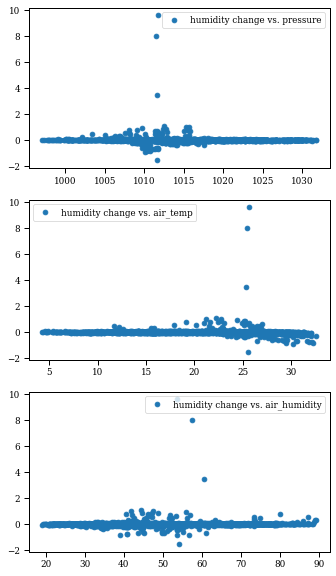

In [8]:
t = pd.to_datetime(data.time, format='%Y-%m-%d %H:%M:%S')
soil_humidity = data.soil_humidity.values
soil_humidity_t = holoborodko_diff(soil_humidity, t)


abscissa = ['pressure', 'air_temp', 'air_humidity']

_, ax = plt.subplots(nrows=len(abscissa), ncols=1, figsize=figsize(1, len(abscissa)))
for row_idx, x in enumerate(abscissa):
    ax[row_idx].scatter(data[x], soil_humidity_t, label=f'humidity change vs. {x}')
    ax[row_idx].legend()
plt.show()

# Bigger time deltas

Average a month worth of data and differentiate.

In [66]:
data_copy = data.copy()
data_copy['time'] = pd.to_datetime(data_copy['time'], format='%Y-%m-%d %H:%M:%S')
data_copy.resample('M', on='time').mean()
soil_humidity_t = holoborodko_diff(data_copy.soil_humidity.values, data_copy.time)
soil_humidity_t

array([ 0.        ,  0.        ,  0.        , ..., -0.31818182,
       -0.36363636, -0.36363636])

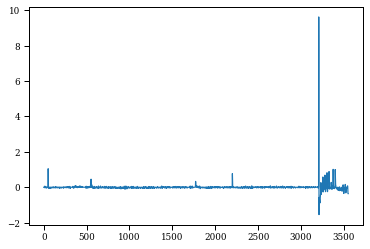

In [67]:
plt.plot(soil_humidity_t)
plt.show()

In [68]:
soil_humidity_t = holoborodko_diff(soil_humidity[::100], t[::100])
soil_humidity_t

array([-0.00967943, -0.00927606, -0.00641885,  0.00021906,  0.00607687,
        0.00862956,  0.00318182, -0.00681818, -0.01511364, -0.01840909,
       -0.01625   , -0.01336329, -0.01208385, -0.01000319, -0.00607192,
       -0.00337371, -0.00057831,  0.00373219,  0.00180801, -0.00488495,
       -0.00534091, -0.00045455,  0.00090909, -0.00227273, -0.00431818,
       -0.00329545, -0.00113636, -0.00011222, -0.00124519, -0.00237646,
       -0.00170256,  0.00340059,  0.02253807,  0.03584351,  0.00949796,
       -0.06840684])

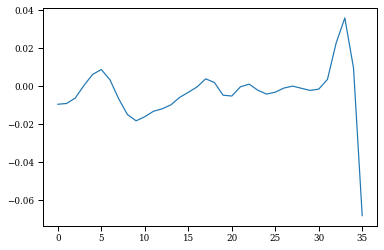

In [69]:
plt.plot(soil_humidity_t)
plt.show()